# **Links**

In [ ]:
#################### DATASET #########################
#   https://drive.google.com/file/d/1M4nP6gV-2s35_VxcxOrLdfoTMfNIIG47/view?usp=sharing

################# SAVED MODEL ########################
#   https://drive.google.com/file/d/160k5h8kCoiFismiy0s_SZMYIBuMpv1PS/view?usp=sharing


# **Download Dataset from my Google Drive**

In [1]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
import zipfile


gdd.download_file_from_google_drive(file_id='1M4nP6gV-2s35_VxcxOrLdfoTMfNIIG47',  #patches aperio
                                        dest_path='./Data_Set.zip',
                                        unzip=False)

zipfile.ZipFile(file="./Data_Set.zip", mode="r").extractall("./")
print('Done extracting dataset')

# **Loading EMNIST Dataset - Balanced**

In [4]:
from scipy import io as spio
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt


emnist = spio.loadmat("matlab/emnist-balanced.mat");


x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)
y_train = emnist["dataset"][0][0][0][0][0][1]
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)
y_test = emnist["dataset"][0][0][1][0][0][1]

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1, order="A").astype('float32') / 255.
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1, order="A").astype('float32') / 255.

y_train = to_categorical(y_train.astype('float32'))
y_test = to_categorical(y_test.astype('float32'))

total_training = x_train.shape[0]
total_test = x_test.shape[0]
input_shape = x_train.shape[1:]


print((x_train.shape, y_train.shape))
print((x_test.shape, y_test.shape))
print(input_shape)



Using TensorFlow backend.


((112800, 28, 28, 1), (112800, 47))
((18800, 28, 28, 1), (18800, 47))
(28, 28, 1)


# **Visualizing the data from EMNIST Dataset**

Text(0.5, 1.0, 'Character: J')

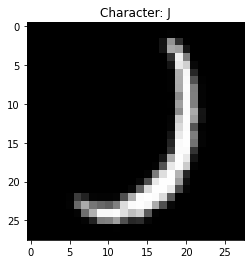

In [47]:
#Visualizing a random sample image from the training set
import numpy.random as rdn

# All classes indexes
class_idx = ['0','1','2','3','4','5','6','7','8','9',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
             'a','b','d','e','f','g','h','n','q','r','t']

sample = int(rdn.random()*total_training)
img = x_train[sample]
plt.imshow(img[:,:,0], cmap='gray')

plt.title("Character: " + str(class_idx[np.argmax(y_train[sample])]))



# **Data Augmentation**

In [ ]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.12,
    height_shift_range=0.12,
    zoom_range=0.1)

train_generator = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
test_generator = datagen.flow(x_test, y_test, batch_size=BATCH_SIZE)

num_train = len(train_generator)
num_test = len(test_generator)


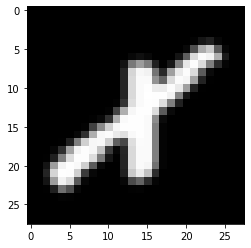

In [42]:
# load only one image from training set
img = x_train[100]

# plotting the original image
plt.imshow(img[:,:,0], cmap='gray')

In [ ]:
# adjusting dimensions to match to the datagen's
img = np.expand_dims(img, axis=0)
iterator_aug = datagen.flow(img)


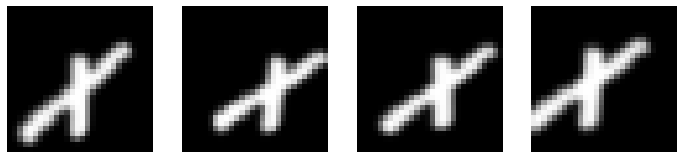

In [46]:
# showing augmented images
f = plt.figure(figsize=(12,6))
for i in range(4):
    img_aug = next(iterator_aug)[0].astype(np.float32)
    sp = f.add_subplot(2, 4, i+1)
    sp.axis('Off')
    plt.imshow(img_aug[:,:,0], cmap='gray')     

# **Building my Network**

This network consists of 3 blocks:



1.   First Block consists of 
  *   3x3 convolution with 64 filters
  *   3x3 convolution with 64 filters
  *   MaxPooling 2x2


2.   Second Block consists of 
  *   3x3 convolution with 128 filters
  *   3x3 convolution with 128 filters
  *   MaxPooling 2x2

3.   Fully connected layer with 47 output neurons 






In [ ]:
# Network
from model.ConvNet import ConvNet

# **Training**

--------------------------------------------------------
Only run the section below if you want to load a previously trained model from a file
--------------------------------------------------------

In [ ]:
loaded_model_path = './model/saved_model.h5'
loaded_model = ConvNet(input_shape, 47).download_model('160k5h8kCoiFismiy0s_SZMYIBuMpv1PS',
                                        loaded_model_path,
                                        download_model_from_drive = True)
loaded_model.summary()

--------------------------------------------------------
Run the section below if you want to train a new model from the beginning
--------------------------------------------------------

In [10]:
model = ConvNet(input_shape, 47).create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0     

In [ ]:
# Compile model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = 'adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import CSVLogger


epochs = 10
batch_size = BATCH_SIZE

log_file = 'log_CNNs.csv'
csv_logger = CSVLogger(log_file, append=True, separator=';')


# Fit model on training data
history = model.fit(x_train,
              y_train,
              batch_size,                 
              epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              callbacks=[csv_logger]
             )

Epoch 1/10
882/882 [==============================] - 1288s 1s/step - loss: 0.6689 - accuracy: 0.7923 - val_loss: 0.4246 - val_accuracy: 0.8602
Epoch 2/10
882/882 [==============================] - 1263s 1s/step - loss: 0.3786 - accuracy: 0.8690 - val_loss: 0.3669 - val_accuracy: 0.8751
Epoch 3/10
882/882 [==============================] - 1260s 1s/step - loss: 0.3256 - accuracy: 0.8830 - val_loss: 0.3685 - val_accuracy: 0.8746
Epoch 4/10
882/882 [==============================] - 1250s 1s/step - loss: 0.2946 - accuracy: 0.8922 - val_loss: 0.3527 - val_accuracy: 0.8804
Epoch 5/10
882/882 [==============================] - 1226s 1s/step - loss: 0.2716 - accuracy: 0.8982 - val_loss: 0.3328 - val_accuracy: 0.8844
Epoch 6/10
882/882 [==============================] - 1243s 1s/step - loss: 0.2520 - accuracy: 0.9036 - val_loss: 0.3388 - val_accuracy: 0.8877
Epoch 7/10
882/882 [==============================] - 1257s 1s/step - loss: 0.2328 - accuracy: 0.9099 - val_loss: 0.3437 - val_accuracy:

# **Evaluating the model on the test set**

In [13]:
# Evaluating my model on test data
loss, accuracy = model.evaluate(x_test, y_test)
print ('Test loss ', loss )
print ('Test accuracy ', accuracy )



588/588 [==============================] - 53s 90ms/step - loss: 0.3654 - accuracy: 0.8871
Test loss  0.3653983473777771
Test accuracy  0.8870744705200195


Text(0.5, 1.0, 'Character: N')

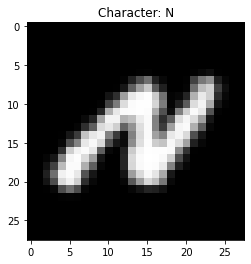

In [14]:
#Visualizing image and its prediction from a random test sample
import numpy.random as rdn


sample = int(rdn.random()*total_test)
img = x_test[sample]
plt.imshow(img[:,:,0], cmap='gray')

img = np.expand_dims(img, axis=0)
predicted_label = model.predict(img)
score = np.argmax(predicted_label)

plt.title("Character: " + str(class_idx[score]))


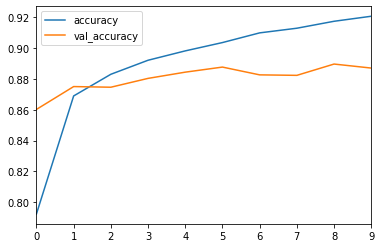

In [15]:
import pandas as pd


# Plotting model accuracy and loss of the model
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()


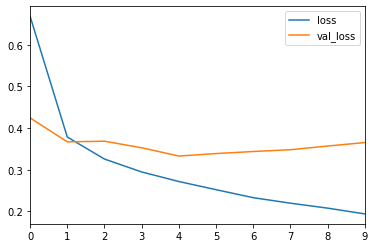

In [18]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()


# **Saving our model**

In [ ]:
!mkdir model
model.save( './model/saved_model.h5' )
